# In this notebook, I am going to put together the models

You bring up an excellent point about ensuring that the freshness classification model only processes fruit classes that are part of your training data. Since YOLOv5s is a pretrained model with many object categories, it might detect non-fruit objects and pass their bounding boxes to the freshness classifier. Here's how you can handle this situation systematically:


Proposed Solution
We can filter YOLOv5 detections based on the specific fruit classes you care about before sending them to the freshness classification model. For all other detected objects, you can mark them as "not in scope of this project."






You bring up an excellent point about ensuring that the freshness classification model only processes fruit classes that are part of your training data. Since YOLOv5s is a pretrained model with many object categories, it might detect non-fruit objects and pass their bounding boxes to the freshness classifier. Here's how you can handle this situation systematically:

Proposed Solution
We can filter YOLOv5 detections based on the specific fruit classes you care about before sending them to the freshness classification model. For all other detected objects, you can mark them as "not in scope of this project."

Implementation Steps
Define a List of Allowed Fruit Classes:

Create a list of classes (e.g., "Apple", "Banana", etc.) that your project is designed to handle.
Use this list to filter YOLOv5 detections.
Modify the Pipeline:

For each bounding box detected by YOLOv5:
Check if the detected class is in your predefined list of fruit classes.
If it is, send the cropped image to the freshness classifier.
If it isn't, mark it as "not in scope of this project."
Show Real-Time Results:

For in-scope objects: Display the bounding box, class name, freshness label, and confidence score.
For out-of-scope objects: Display the bounding box with the label "Not in scope."

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np

class ConvMixer(nn.Module):
    def __init__(self, dim=64, depth=4, kernel_size=5, patch_size=2, n_classes=6):
        super(ConvMixer, self).__init__()
        self.dim = dim
        self.depth = depth
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.n_classes = n_classes

        # Define the convolution layers
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=3 if i == 0 else self.dim,
                      out_channels=self.dim,
                      kernel_size=self.kernel_size,
                      stride=self.patch_size,
                      padding=1)
            for i in range(self.depth)
        ])

        # Calculate the output size with a dummy input of size (128x128)
        dummy_input = torch.randn(1, 3, 128, 128)
        self.flattened_size = self._get_output_size(dummy_input)

        # Define the fully connected layer
        self.fc = nn.Linear(self.flattened_size, self.n_classes)

    def _get_output_size(self, x):
        for conv in self.conv_layers:
            x = F.relu(conv(x))
        return int(torch.prod(torch.tensor(x.size()[1:])).item())

    def forward(self, x):
        for conv in self.conv_layers:
            x = F.relu(conv(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize and load the trained model
freshness_model = ConvMixer()
freshness_model.load_state_dict(torch.load(
    r'C:\Users\cheng\Documents\VSC\Higher_level_CV\Examination_project\saved_models_for_freshness_d\model_freshness_base_model.pth',
    map_location=torch.device('cpu')
))
freshness_model.eval()


ConvMixer(
  (conv_layers): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1-3): 3 x Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  )
  (fc): Linear(in_features=3136, out_features=6, bias=True)
)

In [48]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)


Using cache found in C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-12-8 Python-3.9.10 torch-2.5.1+cpu CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 48.9 GFLOPs
Adding AutoShape... 


In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np

class ConvMixer(nn.Module):
    def __init__(self, dim=64, depth=4, kernel_size=5, patch_size=2, n_classes=6):
        super(ConvMixer, self).__init__()
        self.dim = dim
        self.depth = depth
        self.kernel_size = kernel_size
        self.patch_size = patch_size
        self.n_classes = n_classes

        # Define the convolution layers
        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=3 if i == 0 else self.dim,
                      out_channels=self.dim,
                      kernel_size=self.kernel_size,
                      stride=self.patch_size,
                      padding=1)
            for i in range(self.depth)
        ])

        # Calculate the output size with a dummy input of size (128x128)
        dummy_input = torch.randn(1, 3, 128, 128)
        self.flattened_size = self._get_output_size(dummy_input)

        # Define the fully connected layer
        self.fc = nn.Linear(self.flattened_size, self.n_classes)

    def _get_output_size(self, x):
        for conv in self.conv_layers:
            x = F.relu(conv(x))
        return int(torch.prod(torch.tensor(x.size()[1:])).item())

    def forward(self, x):
        for conv in self.conv_layers:
            x = F.relu(conv(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Initialize and load the trained model
freshness_model = ConvMixer()
freshness_model.load_state_dict(torch.load(
    r'C:\Users\cheng\Documents\VSC\Higher_level_CV\Examination_project\saved_models_for_freshness_d\model_freshness_base_model.pth',
    map_location=torch.device('cpu')
))
freshness_model.eval()


yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5m', pretrained=True)


allowed_fruit_classes = ['apple', 'banana', 'orange']
class_mapping = {
    0: 'Apple_Good', 1: 'Apple_Bad',
    2: 'Banana_Good', 3: 'Banana_Bad',
    4: 'Orange_Good', 5: 'Orange_Bad'
}
freshness_classes = ["spoiled", "fresh"]

def preprocess_image(img, target_size=(128, 128)):  # Use 128x128 to match model's expected input
    # Convert BGR to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Resize to 128x128
    img = cv2.resize(img, target_size)
    img_pil = Image.fromarray(img)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img_pil)
    img_tensor = img_tensor.unsqueeze(0)
    return img_tensor

def predict_freshness(cropped_img):
    img_tensor = preprocess_image(cropped_img)
    freshness_model.eval()
    with torch.no_grad():
        outputs = freshness_model(img_tensor)
        predicted_class = torch.argmax(outputs, dim=1).item()
        predicted_label = class_mapping[predicted_class]

        # Determine freshness label and confidence
        if 'Good' in predicted_label:
            freshness_label = 'Fresh'
            freshness_conf = torch.sigmoid(outputs)[0][predicted_class].item()
        else:
            freshness_label = 'Spoiled'
            freshness_conf = 1 - torch.sigmoid(outputs)[0][predicted_class].item()

    return freshness_label, freshness_conf

def process_frame(frame):
    results = yolo_model(frame)
    detections = results.xyxy[0].cpu().numpy()

    for *box, conf, cls in detections:
        class_name = results.names[int(cls)]
        if class_name in allowed_fruit_classes:
            x1, y1, x2, y2 = map(int, box)
            cropped = frame[y1:y2, x1:x2]
            if cropped.size > 0:
                freshness_label, freshness_conf = predict_freshness(cropped)

                color = (0, 255, 0) if freshness_label == 'Fresh' else (0, 0, 255)
                cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(frame, f"{class_name}: {freshness_label} ({freshness_conf:.2f})",
                            (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return frame

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    processed_frame = process_frame(frame)
    cv2.imshow('Fruit Detection and Freshness Classification', processed_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models

C:\Users\cheng/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


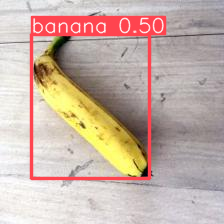

In [43]:
img = r"C:\Users\cheng\Documents\VSC\Higher_level_CV\Examination_project\data\Banana_Good\IMG_0112.JPG"
results = yolo_model(img)
results.show()  # This should open a window with the detection